#### CIFAR10 Attack Notebook

In [1]:
%%capture installation
import os
import pickle
import argparse
import datetime

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.optim as optim
import yaml
from art.attacks.evasion import DeepFool, FastGradientMethod
from art.estimators.classification import PyTorchClassifier

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

from typing import Callable, Tuple, Dict
from pathlib import Path
import pytorch_lightning as pl
from torch import nn

from dataloader import load_mnist
from models.autoencoder import (ANNAutoencoder, BaseAutoEncoder,
                                CelebAAutoencoder, CIFAR10Autoencoder, CIFAR10VAE,
                                CIFAR10LightningAutoencoder, CIFAR10NoisyLightningAutoencoder)
from models.classifier import (CelebAClassifier, CIFAR10Classifier,
                                MNISTClassifier)

from attacks import ATTACK_MAPPINGS, FastGradientMethod
from attacks.art_attack import execute_attack, get_models, get_xyz, hybridize
from attacks.plot_attack import plot_adversarial_images, plot_robust_accuracy
from dataloader import DATALOADER_MAPPINGS

In [62]:
class Args:
    batch_size = 128
    dataset_len = 1000
    attack_name = "fgsm"
    device  = "cuda"
    model_name = "cifar10_cnn_1"
    ae_name = "cnn_256"
    plot = False
    plot_dir = "./plots"
    # kwargs = {}
    kwargs = {"eps": 0.08, "batch_size": 64} # fgsm
    # kwargs = {"batch_size": 32, "nb_grads": 5, "epsilon": 1e-04} # deepfool
    # kwargs = {"eps": 0.5, "batch_size": 128} # pgd and bim
    # kwargs = {"batch_size": 32, "theta": 0.3} # jsma
    # kwargs = {"batch_size": 128} # cnw
    # kwargs = {"batch_size": 128, "targeted": False} # boundary and elastic and signopt

args = Args()

In [63]:
%%capture installation
attack_name = ATTACK_MAPPINGS.get(args.attack_name)
dataset_name = args.model_name.split("_")[0]
print(f"Working on the dataset: {dataset_name}!!!!!")

with open(f"./configs/{dataset_name}.yml", "r") as f:
    config = yaml.safe_load(f)

classifier_model, autoencoder_model, config = get_models(args)
print(f"Loaded classifier and autoencoder models in eval mode!!!!!")

train_dataloader = DATALOADER_MAPPINGS[config["dataset_name"]](batch_size=args.batch_size)
print(f"Loaded dataloader!!!!!")

In [64]:
result = {attack_name.__name__: {}}
xs = []
cas, ras = [], []
x_adv, x_adv_acc, delta_x = [], [], []
modf_x_adv, modf_x_adv_acc = [], []
z_adv, x_hat_adv, x_hat_adv_acc, delta_x_hat = [], [], [], []
orig_time, modf_time = [], []

for i in range(args.dataset_len // args.batch_size):
    x, y, z = get_xyz(args, autoencoder_model, train_dataloader)

    config["latent_shape"] = args.ae_name.split('_')[-1]
    classifier, hybrid_classifier, ca, ra = hybridize(x, y, z, 
                                                        config, classifier_model, autoencoder_model)
    xs.append(x[0])
    cas.append(ca)
    ras.append(ra)
    # Perform attack
    conditionals = {
        "calculate_original": True,
        "is_class_constrained": False
    }
    results: Dict = execute_attack(config, attack_name, x, y, z, classifier, hybrid_classifier, autoencoder_model, args.kwargs, conditionals)[attack_name.__name__]
    # results = result[attack_name.__name__]
    x_adv.append(results["x_adv"])
    x_adv_acc.append(results["x_adv_acc"])
    delta_x.append(results["delta_x"])
    modf_x_adv.append(results["modf_x_adv"])
    modf_x_adv_acc.append(results["modf_x_adv_acc"])
    z_adv.append(results["z_adv"])
    x_hat_adv.append(results["x_hat_adv"])
    x_hat_adv_acc.append(results["x_hat_adv_acc"])
    delta_x_hat.append(results["delta_x_hat"])

    orig_time.append(results["orig_time"])
    modf_time.append(results["modf_time"])

print("Accuracy on benign test examples: {}%".format((sum(cas)/len(cas)) * 100))
print("Accuracy on benign test examples(from reconstructed): {}%".format((sum(ras)/len(ras)) * 100))

result[attack_name.__name__]["x_adv"] = np.vstack(x_adv)
result[attack_name.__name__]["x_adv_acc"] = sum(x_adv_acc) / len(x_adv_acc)
result[attack_name.__name__]["delta_x"] = np.vstack(delta_x)

result[attack_name.__name__]["modf_x_adv"] = np.vstack(modf_x_adv)
result[attack_name.__name__]["modf_x_adv_acc"] = sum(modf_x_adv_acc) / len(modf_x_adv_acc)
result[attack_name.__name__]["z_adv"] = np.vstack(z_adv)
result[attack_name.__name__]["x_hat_adv"] = np.vstack(x_hat_adv)
result[attack_name.__name__]["x_hat_adv_acc"] = sum(x_hat_adv_acc) / len(x_hat_adv_acc)
result[attack_name.__name__]["delta_x_hat"] = np.vstack(delta_x_hat)
xs = torch.vstack(xs)

print("Robust accuracy of original adversarial attack: {}%".format(result[attack_name.__name__]["x_adv_acc"] * 100))
print("Robust accuracy of modified adversarial attack: {}%".format(result[attack_name.__name__]["modf_x_adv_acc"] * 100))
print("Robust accuracy of reconstructed adversarial attack: {}%".format(result[attack_name.__name__]["x_hat_adv_acc"] * 100))

print(f"Time taken for original attack: {sum(orig_time)} seconds")
print(f"Time taken for modified attack: {sum(modf_time)} seconds")

Accuracy on benign test examples: 100.0%
Accuracy on benign test examples(from reconstructed): 95.3125%
Robust accuracy of original adversarial attack: 84.375%
Robust accuracy of modified adversarial attack: 69.53125%
Robust accuracy of reconstructed adversarial attack: 22.65625%
Time taken for original attack: 0.49677109718322754 seconds
Time taken for modified attack: 0.9312136173248291 seconds


In [65]:
if conditionals["calculate_original"]:
    x_adv = result[attack_name.__name__]["x_adv"]
    delta_x = result[attack_name.__name__]["delta_x"]

x_hat_adv  = result[attack_name.__name__]["x_hat_adv"]
modf_x_adv = result[attack_name.__name__]["modf_x_adv"]

# noises
delta_x_hat = result[attack_name.__name__]["delta_x_hat"]

import torchvision
def plot_images(images):
    plt.figure(figsize=(20, 2))
    images = torch.Tensor(images).reshape(-1, 3, 32, 32)
    grid = torchvision.utils.make_grid(images, nrow=10, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

def plot_batch(images):
    plt.figure(figsize=(20, 12))
    images = torch.Tensor(images).reshape(-1, 3, 32, 32)
    grid = torchvision.utils.make_grid(images, nrow=10, normalize=False, range=(0,1))
    grid = grid.permute(1, 2, 0)
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

start = 0
end   = 10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


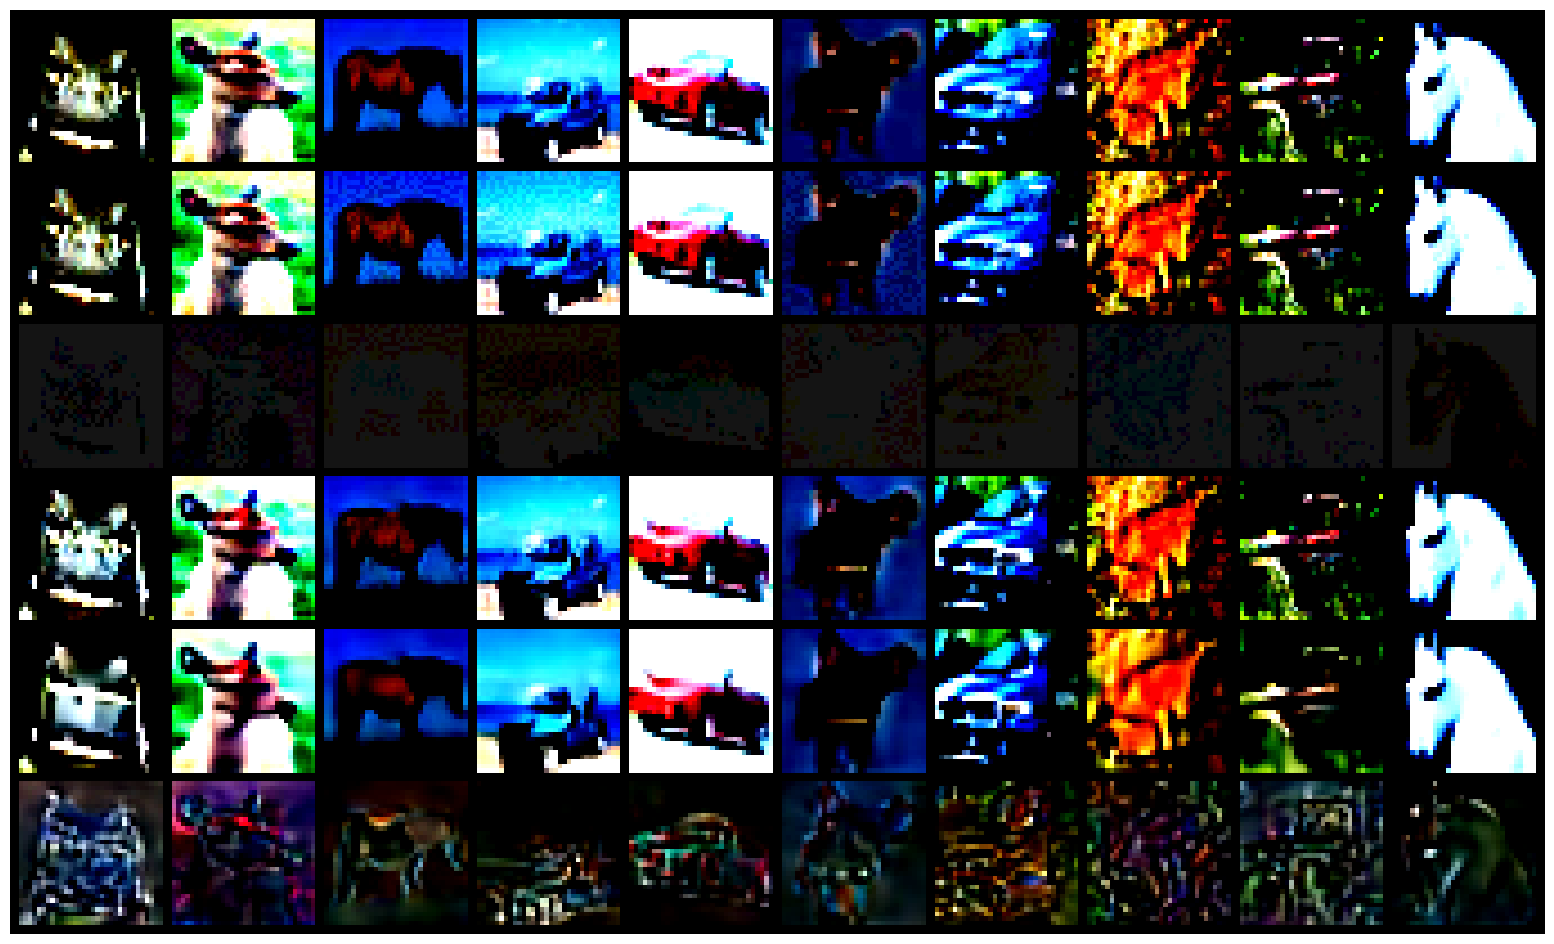

In [66]:
images = np.vstack([x[1][start: end], x_adv[start: end], delta_x[start: end], modf_x_adv[start: end], x_hat_adv[start: end], delta_x_hat[start: end]])
plot_batch(images)

#### LPIPS Similarity Score

In [67]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores

# LPIPS between original and original attacks
import torch
img_orig = torch.Tensor(x_adv) # image should be RGB, IMPORTANT: normalized to [-1,1]
img_modf = torch.Tensor(x_hat_adv)
# img_modf = torch.Tensor(modf_x_adv)
img = xs.detach().cpu()

orig_lpips = loss_fn_alex(img, img_orig)
modf_lpips = loss_fn_alex(img, img_modf)
print("Average LPIPS score of original adversarial attack: ", orig_lpips.flatten().mean())
print("Average LPIPS score of modifed adversarial attack: ", modf_lpips.flatten().mean())

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/harsh/anaconda3/envs/py38/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
Average LPIPS score of original adversarial attack:  tensor(0.0005, grad_fn=<MeanBackward0>)
Average LPIPS score of modifed adversarial attack:  tensor(0.0183, grad_fn=<MeanBackward0>)


In [68]:
## Harmonic Means
orig_acc = result[attack_name.__name__]["x_adv_acc"]
modf_acc = result[attack_name.__name__]["x_hat_adv_acc"]

orig_lpips_avg = orig_lpips.flatten().mean()
modf_lpips_avg = modf_lpips.flatten().mean()

orig_hm = (orig_acc * orig_lpips_avg) / (orig_acc + orig_lpips_avg)
modf_hm = (modf_acc * modf_lpips_avg) / (modf_acc + modf_lpips_avg)

print(f"Original HM: {orig_hm}, Modified HM: {modf_hm}")

Original HM: 0.0004667279135901481, Modified HM: 0.01690153032541275


#### Calculating L2 and Linf Norm

In [69]:
orig_linf = torch.max(torch.abs(xs - img_orig.to(device)))
modf_linf = torch.max(torch.abs(xs - img_modf.to(device)))

print("Average Linf distance between original and original adversarial images: ", orig_linf.mean())
print("Average Linf distance between original and modified adversarial images: ", modf_linf.mean())

Average Linf distance between original and original adversarial images:  tensor(0.0800, device='cuda:0')
Average Linf distance between original and modified adversarial images:  tensor(2.9919, device='cuda:0')


In [44]:
orig_l2 = torch.cdist(xs, img_orig.to(device), p=2)
modf_l2 = torch.cdist(xs, img_modf.to(device), p=2)
print("Average L2 distance between original and original adversarial images: ", orig_l2.mean())
print("Average L2 distance between original and modified adversarial images: ", modf_l2.mean())

Average L2 distance between original and original adversarial images:  tensor(6.5327, device='cuda:0')
Average L2 distance between original and modified adversarial images:  tensor(6.7013, device='cuda:0')


In [17]:
# save adversarial images
fileObj = open(f"./objects/{dataset_name}/{args.attack_name}.pkl", 'wb')
pickle.dump(result, fileObj)
fileObj.close()

In [ ]:
if conditionals["calculate_original"]:
    plot_images(x_adv[start: end])

In [ ]:
if conditionals["calculate_original"]:
    plot_images(delta_x[start: end])

In [ ]:
plot_images(x[1][start: end])

In [ ]:
plot_images(modf_x_adv[start: end])

In [ ]:
plot_images(delta_x_hat[start: end])

In [ ]:
plot_images(x_hat_adv[start: end])

#### Robust Bench Benchmarks

In [40]:
from robustbench.utils import load_model

# model = load_model(model_name='Rebuffi2021Fixing_70_16_cutmix_extra', dataset='cifar10', threat_model='Linf')
model = load_model(model_name='Gowal2021Improving_70_16_ddpm_100m', model_dir="~/scratch/robust_models/", dataset='cifar10', threat_model='Linf')
# model = load_model(model_name='Carmon2019Unlabeled', dataset='cifar10', threat_model='Linf')
# model = load_model(model_name='Engstrom2019Robustness', dataset='cifar10', threat_model='Linf')
# model = load_model(model_name='Rice2020Overfitting', dataset='cifar10', threat_model='Linf')

Download started: path=~/scratch/robust_models/cifar10/Linf/Gowal2021Improving_70_16_ddpm_100m.pt (gdrive_id=10qBoDG_NomJBrRFeTsSwEcJF1GA-sjC4)
Download finished: path=~/scratch/robust_models/cifar10/Linf/Gowal2021Improving_70_16_ddpm_100m.pt (gdrive_id=10qBoDG_NomJBrRFeTsSwEcJF1GA-sjC4)


In [39]:
criterion = nn.CrossEntropyLoss()
classifier = PyTorchClassifier( 
    model=model,
    clip_values=(0, 1),
    loss=criterion,
    # optimizer=optimizer,
    input_shape=(32, 32),
    nb_classes=10,
)

orig_preds = classifier.predict(x_adv)
modf_preds = classifier.predict(x_hat_adv)
orig_acc = np.sum(np.argmax(orig_preds, axis=-1) == y[1]) / len(y[1])
modf_acc = np.sum(np.argmax(modf_preds, axis=-1) == y[1]) / len(y[1])
print("Robust original accuracy: ", orig_acc)
print("Robust modified accuracy: ", modf_acc)

Robust original accuracy:  0.8566666666666667
Robust modified accuracy:  0.64


#### Finding Border

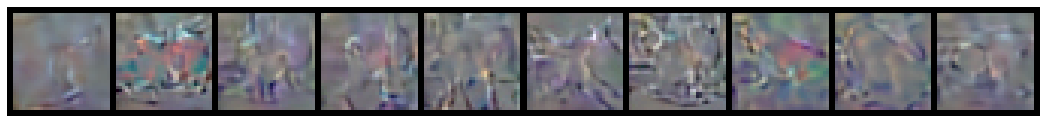

In [82]:
z = autoencoder_model.get_z(x[0][start: end])
noisy_z = z + 0.0001
x_hat = autoencoder_model.get_x_hat(z)
noisy_x_hat = autoencoder_model.get_x_hat(noisy_z)
delta = noisy_x_hat - x_hat
plot_images(delta.cpu().detach())